In [64]:
import os
import sys

script_dir = os.getcwd()
root_dir = f"{script_dir}/../../"
sys.path.append(os.path.join(root_dir, "dpc"))

import numpy as np
import scipy.io
import imageio

import matplotlib.pyplot as plt
%matplotlib inline



import open3d
from open3d import JVisualizer


from util.system import setup_environment
from util.euler import quaternion2euler
from util.image import preprocess_input_image
from render.render_point_cloud import render_point_cloud

#!/usr/bin/env python


import pdb
import time
import torch

from models import model_pc_to as model_pc
from run.ShapeRecords import ShapeRecords
from util.app_config import config as app_config
from util.system import setup_environment
from util.fs import mkdir_if_missing

In [95]:
cfg = app_config

setup_environment(cfg)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dir = cfg.checkpoint_dir
mkdir_if_missing(train_dir)

split_name = "test"
dataset_folder = cfg.inp_dir

dataset = ShapeRecords(dataset_folder, cfg,split_name)
dataset_loader = torch.utils.data.DataLoader(dataset,
                                             batch_size=8, shuffle=False,
                                             num_workers=8,drop_last=True)

log_dir = '../../dpc/run/model_run_data/'
model = model_pc.ModelPointCloud(cfg)
global_step = 100000
if global_step>0:            
    checkpoint_path = os.path.join(log_dir,'model.ckpt_{}.pth'.format(global_step))
    print("Loading from path:",checkpoint_path)
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    global_step_val = checkpoint['global_step']
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    global_step_val = global_step

model = model.to(device)
for i, train_data in enumerate(dataset_loader, 0):
    for k in train_data.keys():
        try:
            train_data[k] = train_data[k].to(device)
        except AttributeError:
            pass
    inputs = model.preprocess(train_data, cfg.step_size)
    outputs = model(inputs, global_step_val, is_training=False, run_projection=True)
    break

Initialized dataset test with size 1355
Loading from path: ../../dpc/run/model_run_data/model.ckpt_100000.pth
Voxel_time 0.6964890760064009


Voxel_time 0.779269414000737


JVisualizer with 1 geometries

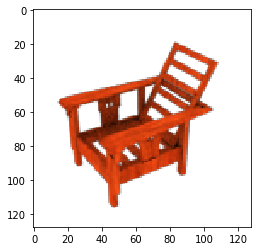

In [197]:
img_idx =30
input_image_np = inputs['images'].detach().cpu().numpy()[img_idx].transpose(1,2,0)

# show input image
plt.imshow(input_image_np)
img2 = inputs['images'][img_idx]
inputs_ = {}
for k in inputs:
    inputs_[k] = inputs[k]
inputs_['images'] = img2.repeat(inputs['images'].shape[0],1,1,1)
outputs = model(inputs_, global_step_val, is_training=False, run_projection=True)
camera_pose_np = outputs['poses'].detach().cpu().numpy()[img_idx]
points_np = outputs['all_points'].detach().cpu().numpy().reshape(-1,4,8000,3)[img_idx,2]
# Interactive visualisation with Open3D
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(np.squeeze(points_np))

visualizer = open3d.JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()

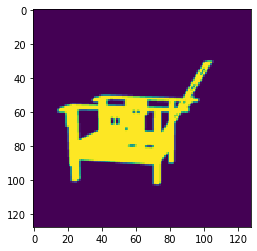

In [195]:
plt.imshow(torch.squeeze(inputs['masks'])[img_idx].cpu().numpy())

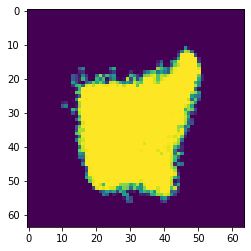

In [198]:
plt.imshow(outputs['projs'].reshape(-1,4,64,64)[img_idx,1].detach().cpu().numpy().squeeze())

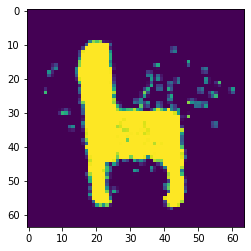

In [67]:
plt.imshow(proj_2[1])

In [137]:
mixed_points = outputs['all_points'][img_idx_2*4]
def mix_points(points_1, points_2, scale_1, scale_2, center_1, center_2):
    points_1 = points_1*scale_1 + center_1
    points_2 = points_2*scale_2 + center_2
    return torch.cat((points_1,points_2),dim=0)
points_1 = outputs['all_points'][img_idx_1*4]
points_2 = outputs['all_points'][img_idx_2*4]
center_1 = torch.from_numpy(np.array([0,0.15,0.15]).reshape(1,3))
center_2 = torch.from_numpy(np.array([0,-0.15,-0.15]).reshape(1,3))
scale_1 = 0.5
scale_2 = 0.5
mixed_points = mix_points(points_1, points_2, scale_1, scale_2, center_1, center_2)

In [139]:
all_points = mixed_points.unsqueeze(0).repeat(128,1,1)
all_rgb = outputs['all_rgb']
camera_pose = outputs['poses'][img_idx_1*4].unsqueeze(0).repeat(128,1)
scaling_factors = outputs['all_scaling_factors'][img_idx_1*4].unsqueeze(0).repeat(128,1)
predicted_translation = outputs["predicted_translation"]

proj_out = pointcloud_project_fast(cfg, all_points, camera_pose, predicted_translation,
                                               all_rgb, _gauss_kernel,
                                               scaling_factor=scaling_factors,
                                               focal_length=outputs['all_focal_length'])
proj = proj_out["proj"]

Voxel_time 0.8630170500000531


In [140]:
projs = torch.squeeze(proj.reshape(32,4,64,64,1)).detach().cpu().numpy()

In [141]:
proj_1 = projs[img_idx_1]
proj_2 = projs[img_idx_2]

In [142]:
print(outputs['all_scaling_factors'].shape)

torch.Size([128, 1])


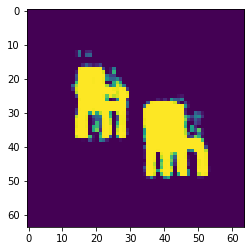